<a href="https://colab.research.google.com/github/rvraghvender/DeepLearningProjects/blob/main/NaturalLanguageProcessing/FineTunningOpenAI/fine_tunning_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning OpenAI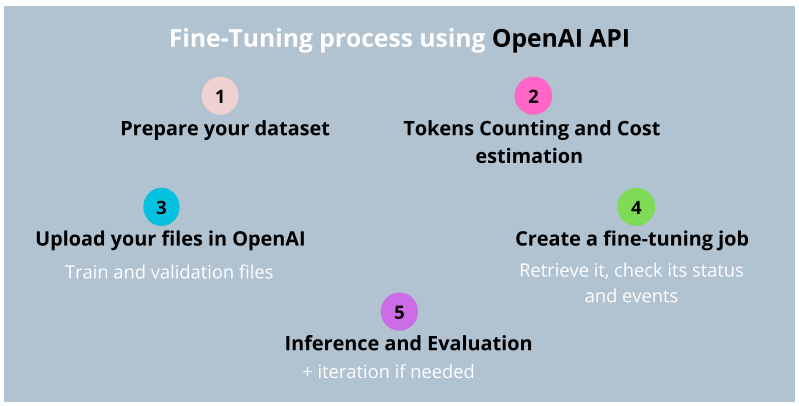

## 1. Install and import libraries

In [ ]:
!pip install openai
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.8 MB/s eta 

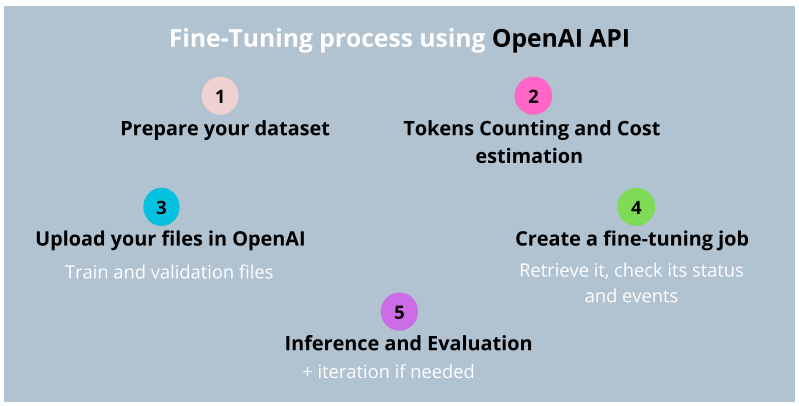

In [ ]:
from IPython import display
display.Image('OpenAi.png')

## 2. Data Preparation for Fine Tunning

We're going to fine-tune GPT-3.5 using an airline tweets dataset to detect sentiments in tweets.

### 2.1 - Loading dataset

#### 2.1.1 - Airline Tweets

In [ ]:
!wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

--2024-01-02 18:24:30--  https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/lkd0eklmi64m9xm/AirlineTweets.csv [following]
--2024-01-02 18:24:31--  https://www.dropbox.com/s/raw/lkd0eklmi64m9xm/AirlineTweets.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc2dcfddb1267d730f30bf6bf39.dl.dropboxusercontent.com/cd/0/inline/CKn_gprMMKBijzlSlOl9BCbU2ReEILkGLoNqpDzgSjoChqyAe58_yS7JSLhtn0ljOhtNkzJBj1eZIawDedizMAwXWDjwK7rmO95fxJBwkh502P_sMUSo7zZF7gzhEJW5nIAF33TIhX2Inv-TQtuZmsGr/file# [following]
--2024-01-02 18:24:32--  https://ucc2dcfddb1267d730f30bf6bf39.dl.dropboxusercontent.com/cd/0/inline/CKn_gprMMKBijzlSlOl9BCbU2ReEILkGLoNqpDzgSjoChqyAe58_yS7JSLhtn0ljOhtNkzJBj1eZIaw

In [ ]:
import pandas as pd
df = pd.read_csv('AirlineTweets.csv')

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### 2.2 - Prepare dataset for Fine Tunning:

#### 2.2.1 - Create message [{role: content}]: For role: system, user, assistant

In [ ]:
training_data = []

system_message = 'You are a helpful assistant. You are to extract the sentiment ' + \
                    'analysis from the provided airline tweets.'

In [ ]:
system_message

'You are a helpful assistant. You are to extract the sentiment analysis from the provided airline tweets.'

In [ ]:
def create_user_message(row):
    return f"Airline: {row['airline']} \n\nTweet: {row['text']}\n\nAirline Sentiment:"

def create_final_message(row):
    messages = []
    messages.append({'role': 'system', 'content': system_message})
    user_message = create_user_message(row)
    messages.append({'role': 'user', 'content': user_message})

    messages.append({'role': 'assistant', 'content': row['airline_sentiment']})

    return {"messages": messages}

In [ ]:
create_final_message(df.iloc[0])

{'messages': [{'role': 'system',
   'content': 'You are a helpful assistant. You are to extract the sentiment analysis from the provided airline tweets.'},
  {'role': 'user',
   'content': 'Airline: Virgin America \n\nTweet: @VirginAmerica What @dhepburn said.\n\nAirline Sentiment:'},
  {'role': 'assistant', 'content': 'neutral'}]}

#### 2.2.2 - Split for Training and validation sets

In [ ]:
print(f'DataFrame shape {df.shape}')

training_df = df.loc[0:600]
training_data = training_df.apply(create_final_message, axis=1).to_list()

for example in training_data[:3]:
    print(example)

DataFrame shape (14640, 15)
{'messages': [{'role': 'system', 'content': 'You are a helpful assistant. You are to extract the sentiment analysis from the provided airline tweets.'}, {'role': 'user', 'content': 'Airline: Virgin America \n\nTweet: @VirginAmerica What @dhepburn said.\n\nAirline Sentiment:'}, {'role': 'assistant', 'content': 'neutral'}]}
{'messages': [{'role': 'system', 'content': 'You are a helpful assistant. You are to extract the sentiment analysis from the provided airline tweets.'}, {'role': 'user', 'content': "Airline: Virgin America \n\nTweet: @VirginAmerica plus you've added commercials to the experience... tacky.\n\nAirline Sentiment:"}, {'role': 'assistant', 'content': 'positive'}]}
{'messages': [{'role': 'system', 'content': 'You are a helpful assistant. You are to extract the sentiment analysis from the provided airline tweets.'}, {'role': 'user', 'content': "Airline: Virgin America \n\nTweet: @VirginAmerica I didn't today... Must mean I need to take another tri

In [ ]:
print(example['messages'][1]['content'])

Airline: Virgin America 

Tweet: @VirginAmerica I didn't today... Must mean I need to take another trip!

Airline Sentiment:


In [ ]:
validation_df = df.loc[600:800]
validation_data = validation_df.apply(create_final_message, axis=1).tolist()

#### 2.2.3 - Convert to jsonL

In [ ]:
import json
import numpy as np

In [ ]:
def write_jsonl(data_list: list, filename: str) -> None:
    with open(filename, 'w') as file_object:
        for ddict in data_list:
            jout = json.dumps(ddict) + '\n'
            file_object.write(jout)

In [ ]:
training_file_name = 'airline_tweets_training.jsonl'
write_jsonl(training_data, training_file_name)

validation_file_name = 'airline_tweets_validation.jsonl'
write_jsonl(validation_data, validation_file_name)

### 2.3 - Tokens count and cost estimation

In [ ]:
# Load the jsonl dataset
with open(training_file_name, 'r', encoding='utf-8') as file_object:
    dataset = [json.loads(line) for line in file_object]

In [ ]:
#Initial dataset stats
print('Num examples: ', len(dataset))

Num examples:  601


In [ ]:
print('First example')
for message in dataset[0]['messages']:
    print(message)

First example
{'role': 'system', 'content': 'You are a helpful assistant. You are to extract the sentiment analysis from the provided airline tweets.'}
{'role': 'user', 'content': 'Airline: Virgin America \n\nTweet: @VirginAmerica What @dhepburn said.\n\nAirline Sentiment:'}
{'role': 'assistant', 'content': 'neutral'}


In [ ]:
# Tokens count
import tiktoken

Different encodings are used in openai: **cl100K__base**, p50k__base, gpt2.

These encodings depend on the model we are using:

For gpt-4, gpt-3.5-turbo, text-embedding-ada-002, we neet to use **cl100k__base**.

In [ ]:
encoding = tiktoken.get_encoding('cl100k_base')

In [ ]:
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))

            if key == 'name':
                num_tokens += tokens_per_name

    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message['role'] == 'assistant':
            num_tokens += len(encoding.encode(message['content']))
    return num_tokens

In [ ]:
num_missing_system = 0
num_missing_user = 0
num_messages = []
message_all_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        num_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        num_missing_user += 1
    num_messages.append(len(messages))
    message_all_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num messages missing system message:", num_missing_system)
print("Num messages missing user message:", num_missing_user)
print("\nSome statistics:")
print(f"min={min(message_all_lens)}, max={max(message_all_lens)}")
print(f"p5={np.quantile(message_all_lens, 0.1)}, p95={np.quantile(message_all_lens, 0.95)}")

print("\Examples of tokens nbr from the first messages")
print(message_all_lens[:5])

num_sample_token_long = sum(l > 4096 for l in message_all_lens)
if num_sample_token_long>0:
    print(f"\n{num_sample_token_long} messages may be over the 4096 token limit, they will be truncated during fine-tuning")
else:
    print(f"\nNo message will be truncated during fine-tuning")


Num messages missing system message: 0
Num messages missing user message: 0

Some statistics:
min=52, max=120
p5=60.0, p95=88.0
\Examples of tokens nbr from the first messages
[59, 63, 65, 76, 62]

No message will be truncated during fine-tuning


In [ ]:
# Epochs: Number of time the model is going through the training dataset
# For production, you may need to put a higher value for epochs

In [ ]:
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25
n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)

if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in message_all_lens)
print(f"Dataset contains ~{n_tokens_in_dataset} tokens, which will incur␣training charges")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_tokens_in_dataset} tokens")
print(f"The final cost will be ~{n_epochs * n_tokens_in_dataset/1000 * 0.008}$")

Dataset contains ~44354 tokens, which will incur␣training charges
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~133062 tokens
The final cost will be ~1.064496$


In [ ]:
# from IPython import display
# display.Image(path_image)

# 3 - Fine Tuning process

In [ ]:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

SecretNotFoundError: ignored

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=openai_api_key)

### 3.1 - Upload files in OpenAI

In [ ]:
training_file_creation = client.files.create(
    file=open(training_file_name, 'rb'),
    purpose='fine-tune'
)

In [ ]:
training_file_creation

FileObject(id='file-1FBjV8rg9HxvUD7yb5roEQU0', bytes=234597, created_at=1704230765, filename='airline_tweets_training.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
id_file_training = training_file_creation.id

In [ ]:
validation_file_creation = client.files.create(
    file=open(validation_file_name, "rb"),
    purpose='fine-tune'
)

In [ ]:
validation_file_creation

FileObject(id='file-qhjnqw29xhvKAK9tybzRJv9v', bytes=77406, created_at=1704230778, filename='airline_tweets_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
id_file_validation = validation_file_creation.id

In [ ]:
## To delete files
# client.files.delete(validation_file_creation.id)

### 3.2 - Create Fine Tuninng Job

In [ ]:
fine_tuning_job = client.fine_tuning.jobs.create(training_file=id_file_training,
                                                model='gpt-3.5-turbo',
                                                suffix='airline_sentiment',
                                                validation_file=id_file_validation)

BadRequestError: ignored

#### 3.2.1 - Get job specification: id, model name, status

In [ ]:
fine_tuning_job
# status at the beginning ==> Validating_files
# The current status of the fine-tuning job, which can be either validating_files, queued, running,
# succeed, failed, or cancelled.

In [ ]:
job_id = fine_tunning_job.id
job_id

### 3.3 - List fine-tuned jobs

To get the list of all your jobs (running or finished):

In [ ]:
client.fine_tuning.jobs.list()#.data[0]

In [ ]:
# client.fine_tuning.jobs.list() ==> list of all your fine-tuning jobs
# ==> id
# ==> fine_tuned_model ==> the name of your finetuned model with the suffix you specified in your call
# ==> model ==> the last final model available in OpenAI ==> 'gpt-3.5-turbo-0613'
# ==> status ==> "suceeded" when it has finished correctly

In [ ]:
client.fine_tuning.jobs.list().data[0]
# job_id = 'ftjob-OWg7WZaUPIEnFFOJgBLTS5PO'
# job_id = client.fine_tuning.jobs.list().data[0].id

### 3.4 - Cancel a fine-tuned job

In [ ]:
# client.fine_tuning.jobs.cancel(fine_tuning_job_id = job_id)

### 3.5 - Retrieve Fine-tuned job

To retrieve a given job by its id: Check the "status": running, succeeded

In [ ]:
retrieve_fine_tuned_job = client.fine_tuning.jobs.retrieve(job_id)
retrieve_fine_tuned_job

In [ ]:
retrieve_fine_tuned_job

### 3.6 - List events for fine-tuned job

In [ ]:
events_list_job = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=50)
events = events_list_job.data
events.reverse()
for event in events:
print(event.message)

## 4 - Inference

### 4.1 -Model name once fine-tuned is finished

In [ ]:
retrieve_fine_tuned_job = client.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = retrieve_fine_tuned_job.fine_tuned_model
if fine_tuned_model_id is None:
raise RuntimeError("Fine-tuned model ID not found. Your job has likely not been completed yet.")
print("Fine-tuned model ID:", fine_tuned_model_id)

### 4.2 - Inference: Using Chat Completion with the fine-tuned model

In [ ]:
df.shape

#### 4.2.1 - Using chat completion for a given tweet example

In [ ]:
test_df = df.loc[800:1000]
test_row = test_df.iloc[10]
test_messages = []
test_messages.append({"role": "system", "content": system_message})
user_message = create_user_message(test_row)
test_messages.append({"role": "user", "content": create_user_message(test_row)})
print(test_messages)

In [ ]:
response = client.chat.completions.create(
model=fine_tuned_model_id,
messages=test_messages
)
print(f"Tweet = {test_row['text']}")
print(f"\nrole: {response.choices[0].message.role}, content : {response.choices[0].message.content}")

#### 4.2.2 - Using chat completion for the test dataset tweets

In [ ]:
def create_final_message_test(row):
    test_messages = []
    test_messages.append({"role": "system", "content": system_message})
    user_message = create_user_message(row)
    test_messages.append({"role": "user", "content": create_user_message(row)})
    return test_messages

In [ ]:
%%time
finetuned_model_resp =[]
for i in range(0, len(test_df)):
    row = test_df.iloc[i]
    messages_test = create_final_message_test(row)
    response = client.chat.completions.create(
                model=fine_tuned_model_id,
                messages=messages_test)
# print(f"\nTweet = {row['text']}")
# print(f"role: {response.choices[0].message.role}, content : {response.choices[0].message.content}")
# print(f"Tweet = {row['airline_sentiment']}")
finetuned_model_resp.append(response.choices[0].message.content)

In [ ]:
test_df['result'] = finetuned_model_resp

In [ ]:
print(f"different classes in the y_true {test_df['airline_sentiment'].unique()}")
print(f"different classes in the y_pred {test_df['result'].unique()}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = test_df['airline_sentiment'].values
accuracy = accuracy_score(y_true, finetuned_model_resp)
precision = precision_score(y_true, finetuned_model_resp, average=None)
recall = recall_score(y_true, finetuned_model_resp,average=None)
f1 = f1_score(y_true, finetuned_model_resp,average=None)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")